In [36]:
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from battery_energy_trader.data_handler import DataHandler


%reload_ext autoreload
%autoreload 2

## Data Exploration

Exploration and comparison of two data sets: hourly and 15-minute electricity prices for the first 6 months of 2022. 

- **Data Sets:** 
  - 60-minute data: Prices for hourly contracts.
  - 15-minute data: Prices for 15-minute contracts.
- **Objective:** Summarize and compare the statistical properties of both data sets to identify patterns and differences.
- **Analysis:** Identify which type of contract (hourly or 15-minute) might be more beneficial for trading, considering patterns and market behavior.


In [37]:
# Initialize the data handler and load the data
data_handler_60 = DataHandler('data/Day-ahead_Prices_60min.csv', freq=60)

data_handler_15 = DataHandler('data/Day-ahead_Prices_15min.csv', freq=15)

### Statistical Summary for 60-minute data


In [38]:
print(data_handler_60.data["Day-ahead Price [EUR/MWh]"].describe())

count    4344.000000
mean      185.809573
std        90.647697
min       -19.040000
25%       122.155000
50%       189.005000
75%       232.927500
max       700.000000
Name: Day-ahead Price [EUR/MWh], dtype: float64


### Statistical Summary for 15-minute data


In [39]:
print(data_handler_15.data["Day-ahead Price [EUR/MWh]"].describe())

count    17376.000000
mean       186.970537
std        102.877130
min       -149.990000
25%        127.857500
50%        184.620000
75%        237.472500
max       2999.990000
Name: Day-ahead Price [EUR/MWh], dtype: float64


We can already see that the std is higher for the 15min data -> potentially more outliers. We can also see that the min max spikes are significantly larger. Which would be interesting for our trading approach and the fast reacting nature of Lithium batteries.


Lets now plot the price distribution

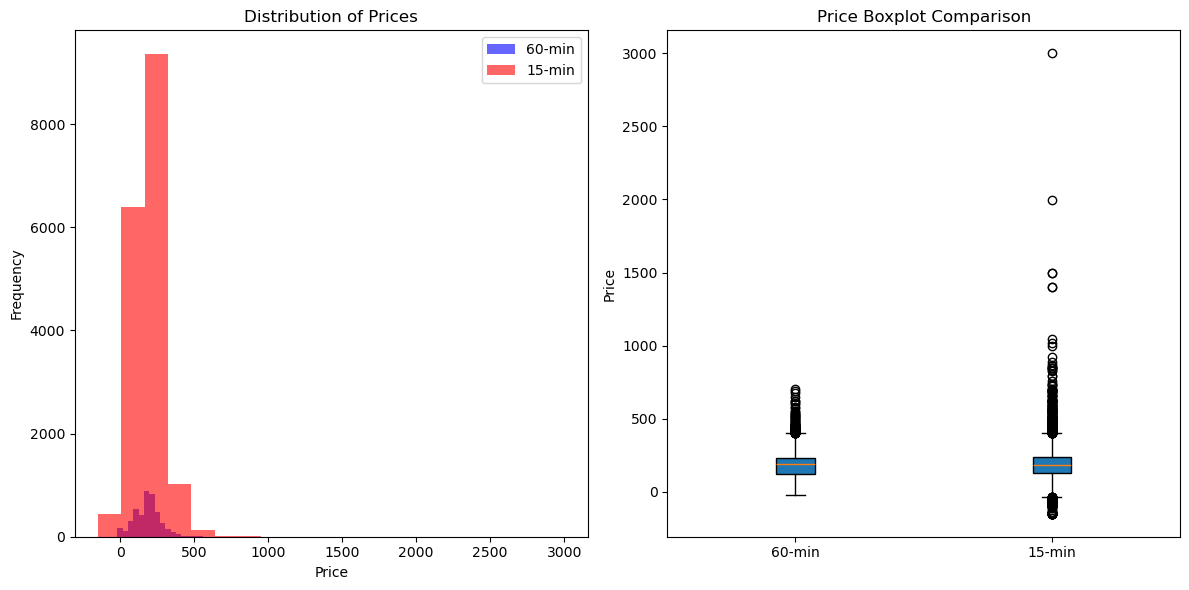

In [40]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(data_handler_60.data['Day-ahead Price [EUR/MWh]'], bins=20, alpha=0.6, label='60-min', color='blue')
plt.hist(data_handler_15.data['Day-ahead Price [EUR/MWh]'], bins=20, alpha=0.6, label='15-min', color='red')
plt.legend()
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot([data_handler_60.data['Day-ahead Price [EUR/MWh]'], data_handler_15.data['Day-ahead Price [EUR/MWh]']], labels=['60-min', '15-min'], patch_artist=True)
plt.title('Price Boxplot Comparison')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


We can now see the outliers clearly. We can also see that the box plots are almost the same though.
Lets have a look at those outliers.

In [41]:
def outlier_detection(data, threshold=3):
    # Add a new column for Z-scores of the prices
    data['Z-Score'] = zscore(data['Day-ahead Price [EUR/MWh]'])

    # Filter outliers
    outliers = data[np.abs(data['Z-Score']) > threshold]
    print(f'Number of outliers: {len(outliers)}')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Day-ahead Price [EUR/MWh]'], label='Original Data')
    plt.scatter(outliers.index, outliers['Day-ahead Price [EUR/MWh]'], color='red', label='Outliers')
    plt.legend()
    plt.show()

Number of outliers: 31


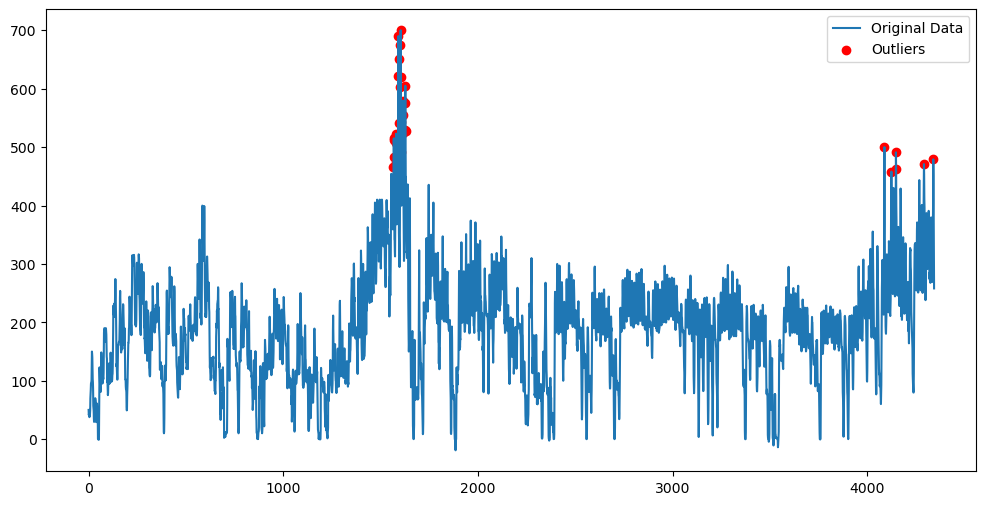

Number of outliers: 163


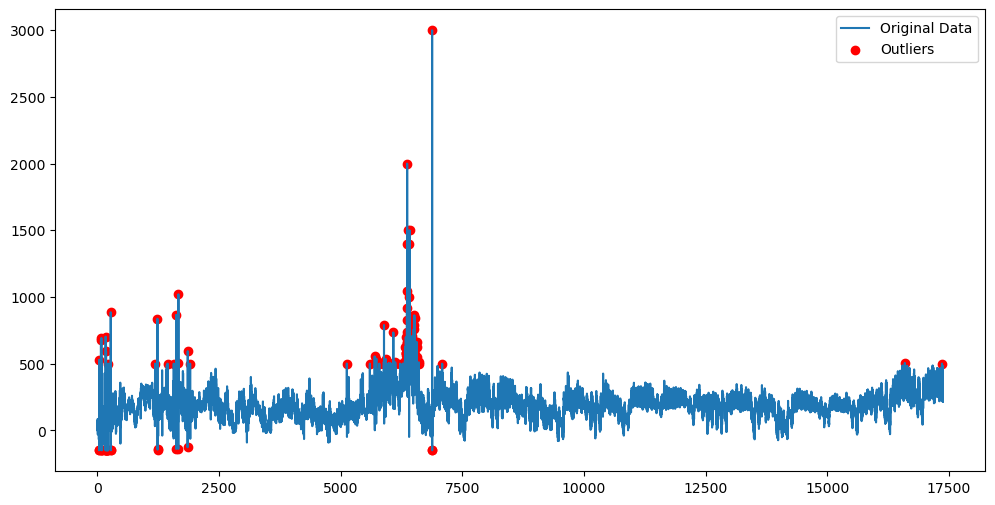

In [42]:
outlier_detection(data_handler_60.data, threshold=3)
outlier_detection(data_handler_15.data, threshold=3)

Confirming our previous analysis

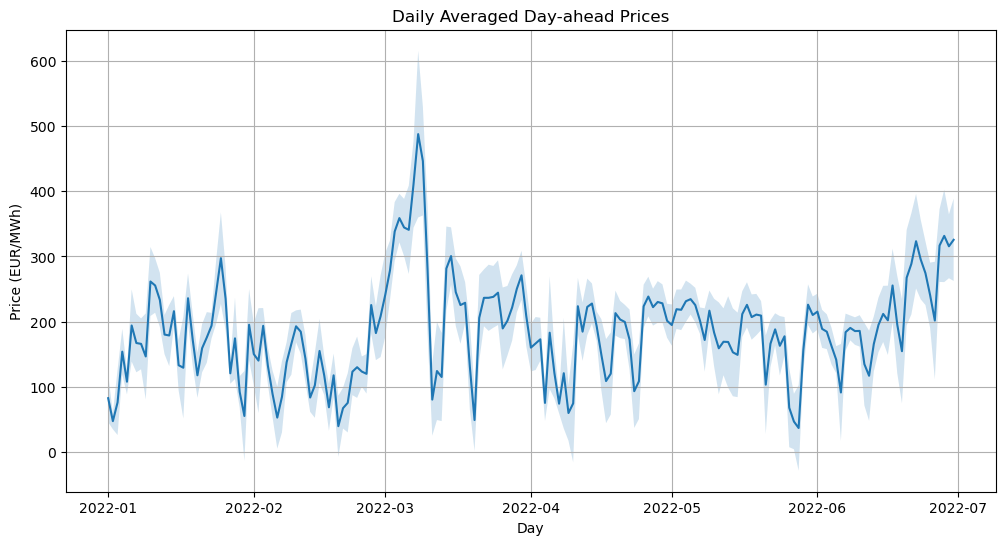

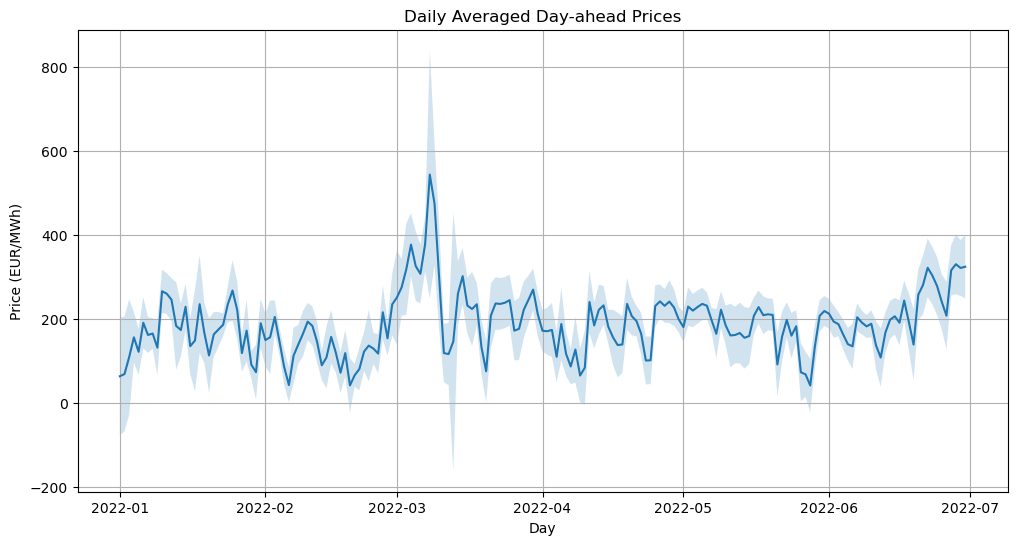

In [43]:
# Plot daily averaged prices for both datasets
data_handler_60.plot_price_daily_averaged(plot_variance=True)
data_handler_15.plot_price_daily_averaged(plot_variance=True)

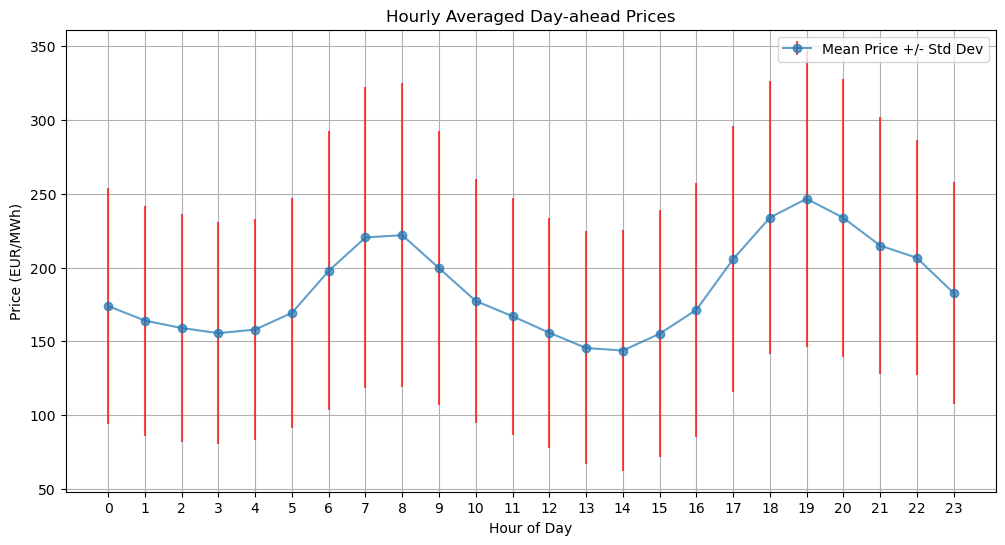

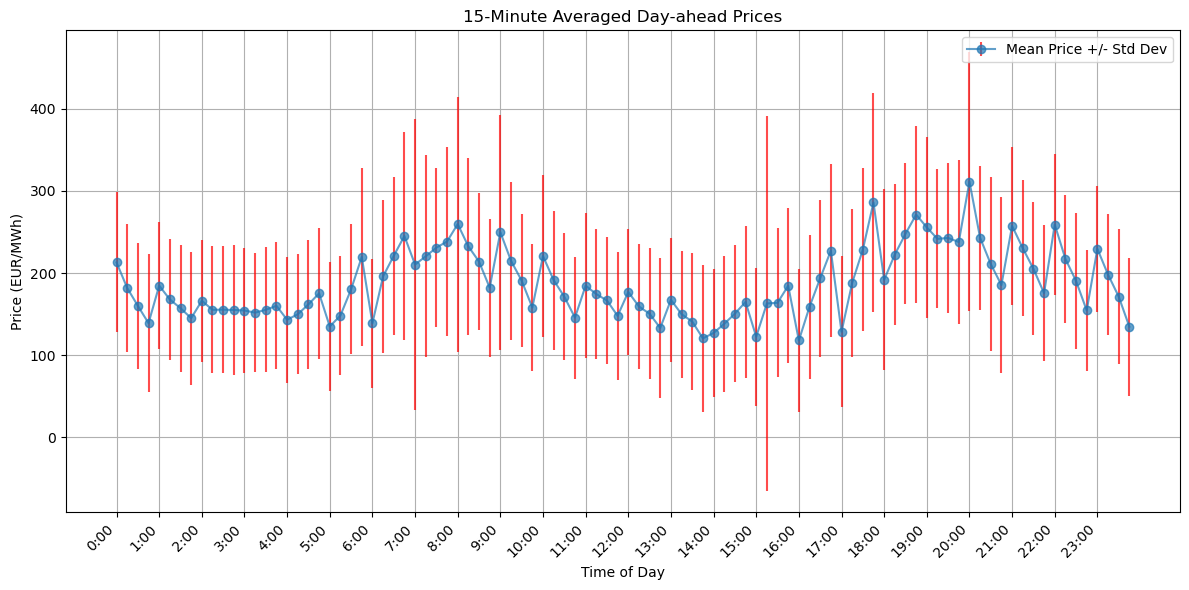

In [44]:
# Plot averaged prices for both datasets
data_handler_60.plot_hourly_price_averaged(plot_variance=True)
data_handler_15.plot_15min_price_averaged(plot_variance=True)

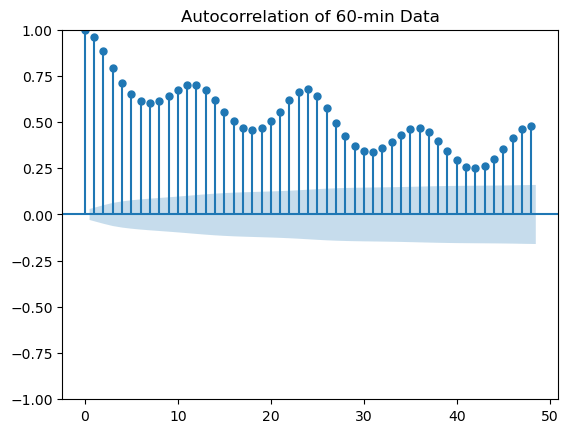

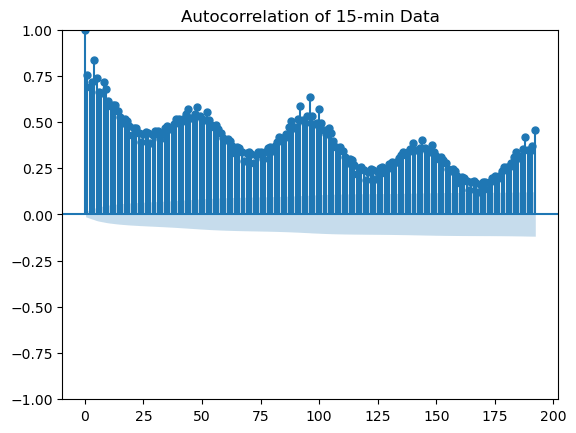

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plotting ACF for 60-minute data
plot_acf(data_handler_60.data['Day-ahead Price [EUR/MWh]'], lags=48) # 48 lags for 2 days in 60-min data
plt.title('Autocorrelation of 60-min Data')
plt.show()

# Plotting ACF for 15-minute data
plot_acf(data_handler_15.data['Day-ahead Price [EUR/MWh]'], lags=192) # 192 lags for 2 days in 15-min data
plt.title('Autocorrelation of 15-min Data')
plt.show()


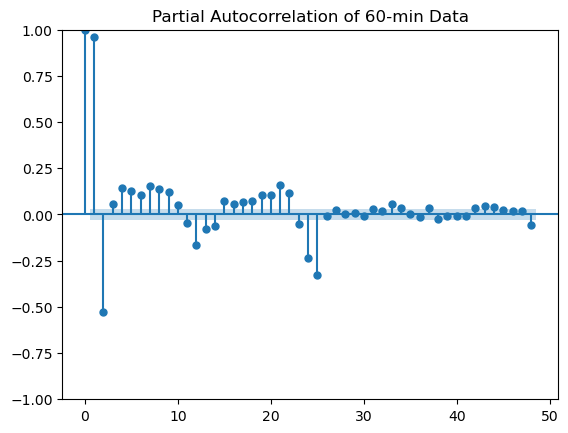

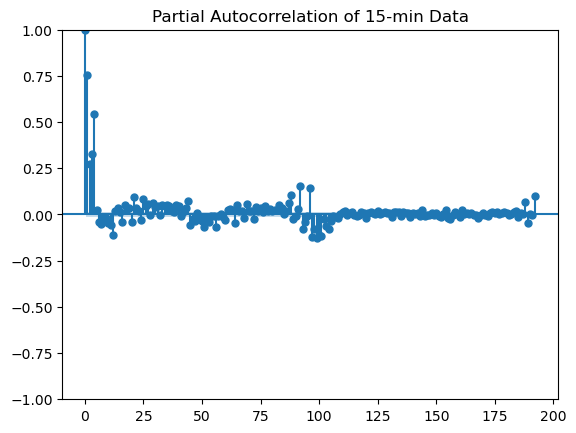

In [46]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting PACF for 60-minute data
plot_pacf(data_handler_60.data['Day-ahead Price [EUR/MWh]'], lags=48) # 48 lags for 2 days
plt.title('Partial Autocorrelation of 60-min Data')
plt.show()

# Plotting PACF for 15-minute data
plot_pacf(data_handler_15.data['Day-ahead Price [EUR/MWh]'], lags=192) # 192 lags for 2 days
plt.title('Partial Autocorrelation of 15-min Data')
plt.show()


We can run a sesonal decomposition from statsmodels to visualize the seasonality and trends a bit better:


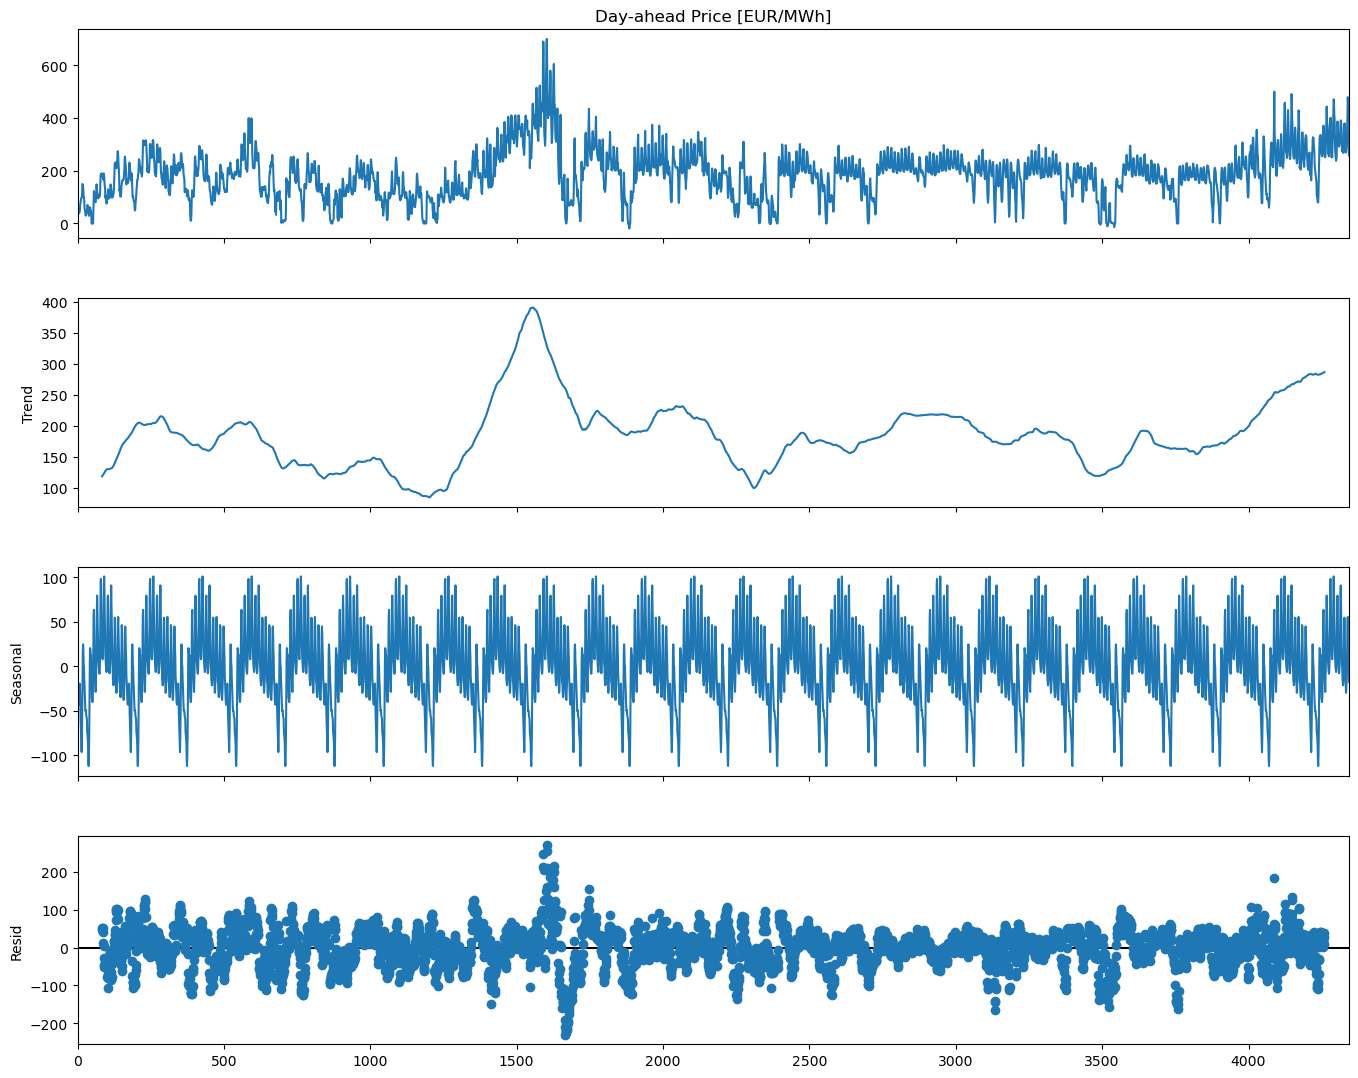

In [26]:
# Decompose the time series
result = seasonal_decompose(data_handler_60.data['Day-ahead Price [EUR/MWh]'], model='additive', period=24*7)  # Weekly seasonality

# Plot the decomposed components
fig = result.plot()
fig.set_size_inches(15, 12)
plt.show()


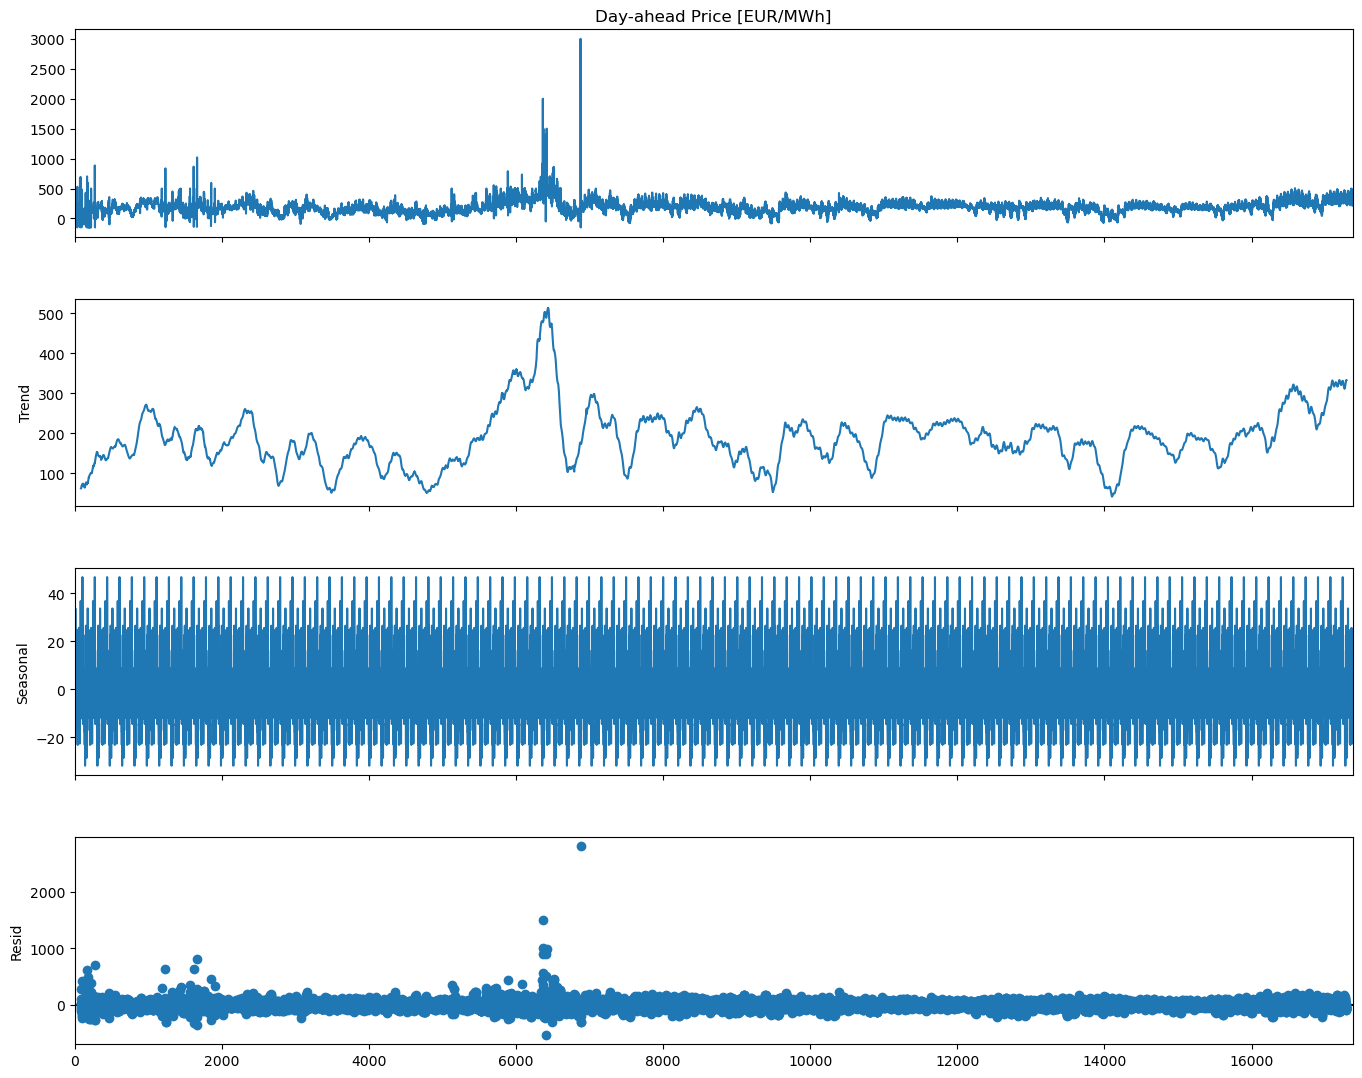

In [12]:
# Decompose the time series
result = seasonal_decompose(data_handler_15.data['Day-ahead Price [EUR/MWh]'], model='additive', period=24*7)  # Weekly seasonality

# Plot the decomposed components
fig = result.plot()
fig.set_size_inches(15, 12)
plt.show()


In [27]:
def plot_rolling_average(data, window=24*7):
    # Calculate the 7-day rolling average
    rolling_avg = data['Day-ahead Price [EUR/MWh]'].rolling(window=window).mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Day-ahead Price [EUR/MWh]'], label='Original Data')
    plt.plot(rolling_avg.index, rolling_avg, color='red', label='7-Day Rolling Average', linewidth=2)
    plt.legend()
    plt.show()


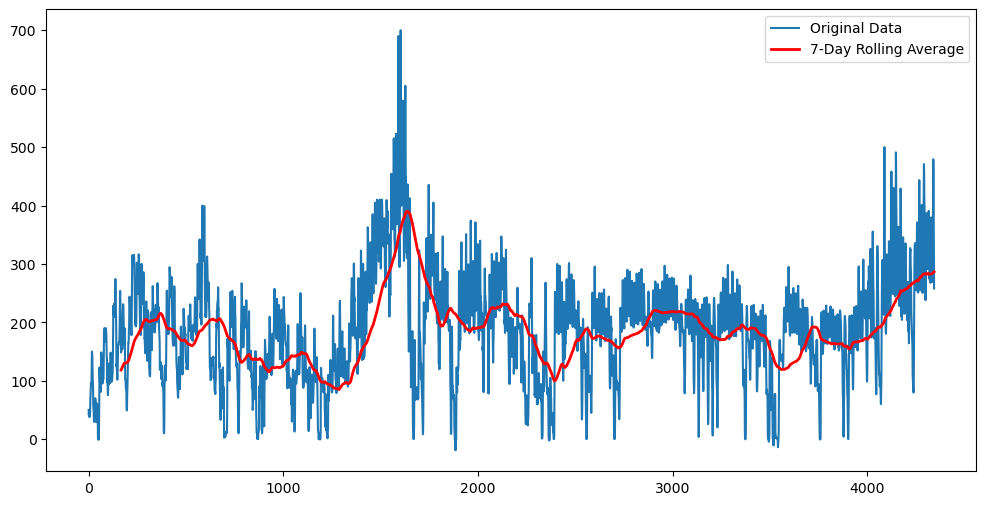

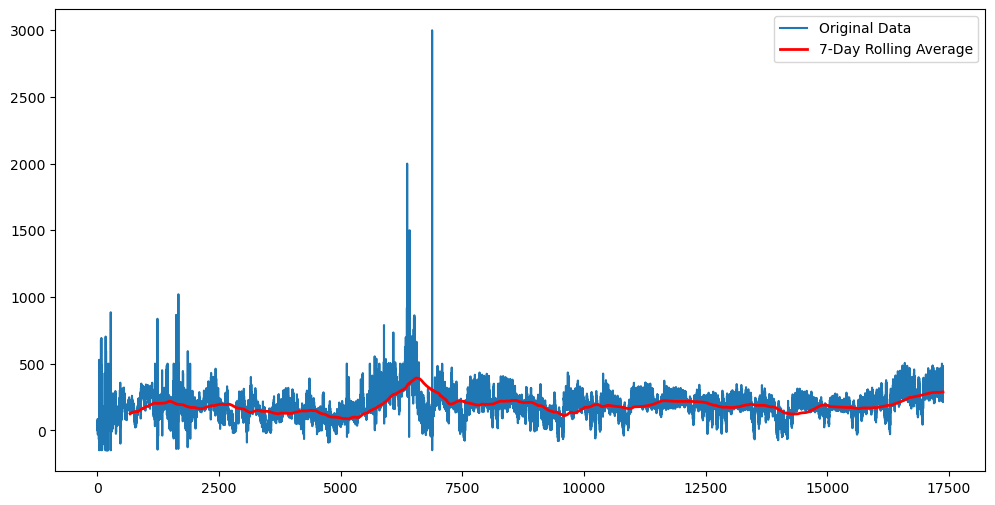

In [28]:
plot_rolling_average(data_handler_60.data, window=24*7)
plot_rolling_average(data_handler_15.data, window=24*4*7)

# Summary

The 15-minute data shows higher daily volatility, providing potentially more opportunities for profit through frequent trading. The higher resolution data may also enable more accurate forecasting and operational flexibility. 
It has to be pointed out though, that the std stems partially from the outliers in the 15min data.

Predictions day ahead might become tricky though due to it's high volaitility.

In [29]:
import cvxpy as cp

from battery_energy_trader.data_handler import DataHandler
from battery_energy_trader.optimizer import Optimizer


%reload_ext autoreload
%autoreload 2

(CVXPY) Apr 08 12:20:39 AM: Encountered unexpected exception importing solver CBC:
ImportError("dlopen(/Users/matthiaskiller/miniforge3/envs/battery_energy_trader_3/lib/python3.9/site-packages/cylp/cy/CyCoinIndexedVector.cpython-39-darwin.so, 0x0002): symbol not found in flat namespace '__ZN9CoinError12printErrors_E'")


In [30]:
optimizer = Optimizer(data_handler=data_handler_15, battery_capacity=1, max_power=1, efficiency=1)

In [31]:
optimizer.optimize_milp(time_horizon=1, solver=cp.GLPK_MI, constraints_soc_end=False)

Total profit: 326150.29 EUR


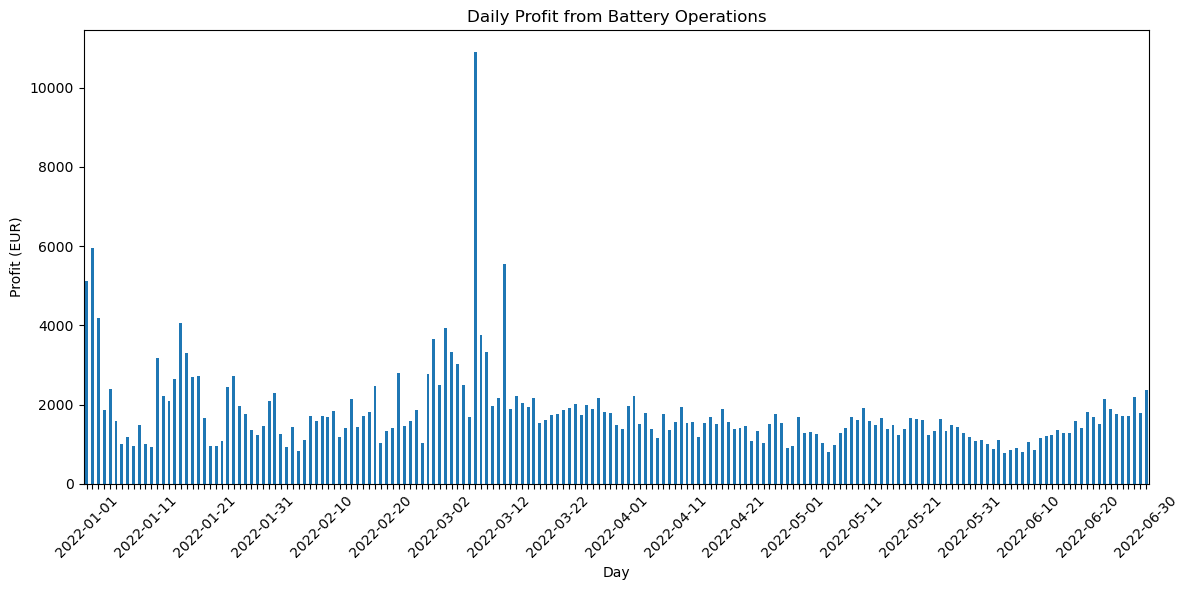

In [33]:
data_handler_15.plot_daily_profit()

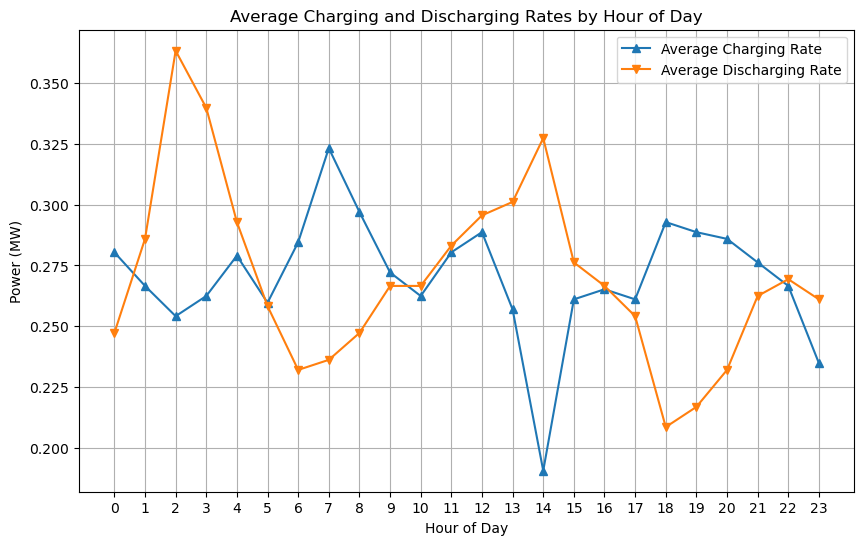

In [34]:
data_handler_15.plot_averaged_charge_discharge_over_day()